In [2]:
from utils import get_data
import os.path as op
import os
import arviz as az

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, f'derivatives/cogmodels_magjudge')

df = get_data(bids_folder)

number of subjects found: 66
number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


In [ ]:
from bauer.models import FlexibleNoiseComparisonModel

model_label = 'flexNoise1'
model = FlexibleNoiseComparisonModel(df)

In [15]:
from bauer.models import FlexibleNoiseComparisonRegressionModel

model_label = 'flexNoiseReg1'
model = FlexibleNoiseComparisonRegressionModel(df, {'n1_evidence_sd':'group', 'n2_evidence_sd':'group'},  
                                                fit_seperate_evidence_sd=True,
                                                fit_prior=False,
                                                polynomial_order=5, 
                                                memory_model='independent')
model.build_estimation_model(df)


/Users/mrenke/git/bauer/bauer/models.py:1294: UserWarning: Found n1_evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')
/Users/mrenke/git/bauer/bauer/models.py:1294: UserWarning: Found n2_evidence_sd in regressors, will add it for all 5 splines!
  warn(f'Found {key} in regressors, will add it for all {po} splines!')


In [ ]:
target_accept = 0.9
burnin=1000
samples=1000

model.build_estimation_model(df)

trace = model.sample(burnin, samples, target_accept=target_accept)

az.to_netcdf(trace,
                op.join(target_folder, f'model-{model_label}_trace.netcdf'))

### load in trace

In [4]:
trace = az.from_netcdf(op.join(target_folder, f'model-{model_label}_trace.netcdf'))

In [22]:
import pandas as pd
import numpy as np

def get_pars(trace, par = 'n1_'):
    n_polynomials = 5

    intercept_pars = pd.concat([trace.posterior[f'{par}evidence_sd_spline{spline_n}_mu'].to_dataframe().xs('Intercept', level=-1) for spline_n in range(1, n_polynomials+1)], axis=1)
    group_pars =  pd.concat([trace.posterior[f'{par}evidence_sd_spline{spline_n}_mu'].to_dataframe().xs('group', level=-1) for spline_n in range(1, n_polynomials+1)], axis=1)

    control = intercept_pars
    dyscalculic = intercept_pars + group_pars

    x = np.linspace(5, 50)
    
    dm = model.make_dm(x, variable=f'{par}evidence_sd')
    evidence_sd_c = pd.DataFrame(dm.dot(control.T),
                                        index=pd.Index(x, name='x'),
                                        columns=control.index).stack([0, 1]).to_frame('sd')

    evidence_sd_d = pd.DataFrame(dm.dot(dyscalculic.T),
                                            index=pd.Index(x, name='x'),
                                            columns=dyscalculic.index).stack([0, 1]).to_frame('sd')

    evidence_sd = pd.concat([evidence_sd_c, evidence_sd_d], keys=['control', 'dyscalculic'], names=['group'], axis=0)

    return evidence_sd #control, dyscalculic



In [18]:
import arviz as az
def get_hdi(d):
    return pd.Series(az.hdi(d.values, hdi_prob=0.95), index=['hdi025', 'hdi975'])

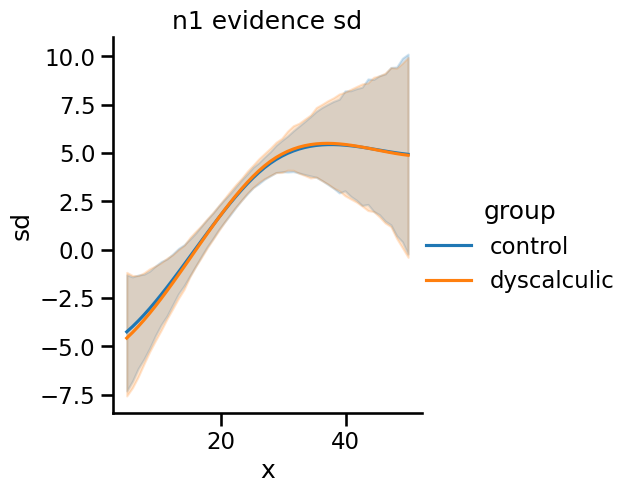

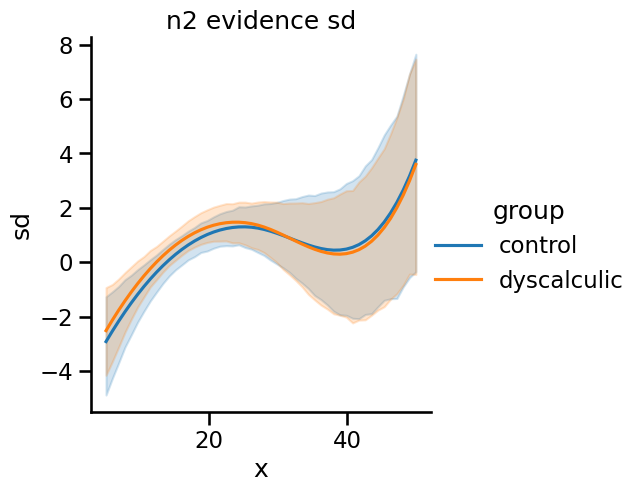

In [25]:
import seaborn as sns
sns.set_context('talk')

for par in ['n1', 'n2']:
    evidence_sd = get_pars(trace, par = f'{par}_')
    g = sns.relplot(data=evidence_sd.reset_index(), x='x', y='sd', hue='group', kind='line', errorbar=get_hdi)
    g.set(title=f'{par} evidence sd')


### no regression

In [ ]:
n1_evidence_sd = model.get_sd_curve(trace, variable='n1_evidence_sd', group=True)
n2_evidence_sd = model.get_sd_curve(trace, variable='n2_evidence_sd', group=True)

import pandas as pd
evidence_sd = pd.concat((n1_evidence_sd, n2_evidence_sd), axis=1).stack().to_frame('sd')

###

base = np.array([5, 7, 10, 14, 20])

In [27]:
df['n2'].max()

56.0